# Floating Point Conversion and Quantization Demo

This notebook demonstrates the usage of floating-point conversion and weight quantization functionality.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from hardware_accelerators.dtypes import Float8, BF16, convert_float_type, quantize_weights

## 1. Direct Floating Point Conversion

Let's test converting between BF16 and Float8 formats.

In [2]:
# Create some test values in BF16
test_values = [0.125, 0.5, 1.0, 1.5, 2.0, -0.5, -1.0, -2.0]
bf16_vals = [BF16(x) for x in test_values]

# Convert to Float8
fp8_vals = [convert_float_type(x, Float8) for x in bf16_vals]

# Convert back to BF16
bf16_reconverted = [convert_float_type(x, BF16) for x in fp8_vals]

# Print results
print("Value Comparison:")
print("Original -> Float8 -> BF16")
for orig, fp8, bf16 in zip(test_values, fp8_vals, bf16_reconverted):
    print(f"{orig:6.3f} -> {float(fp8):6.3f} -> {float(bf16):6.3f}")

Value Comparison:
Original -> Float8 -> BF16
 0.125 ->  0.125 ->  0.125
 0.500 ->  0.500 ->  0.500
 1.000 ->  1.000 ->  1.000
 1.500 ->  1.500 ->  1.500
 2.000 ->  2.000 ->  2.000
-0.500 -> -0.500 -> -0.500
-1.000 -> -1.000 -> -1.000
-2.000 -> -2.000 -> -2.000


## 2. Weight Quantization

Now let's test weight quantization with different approaches.

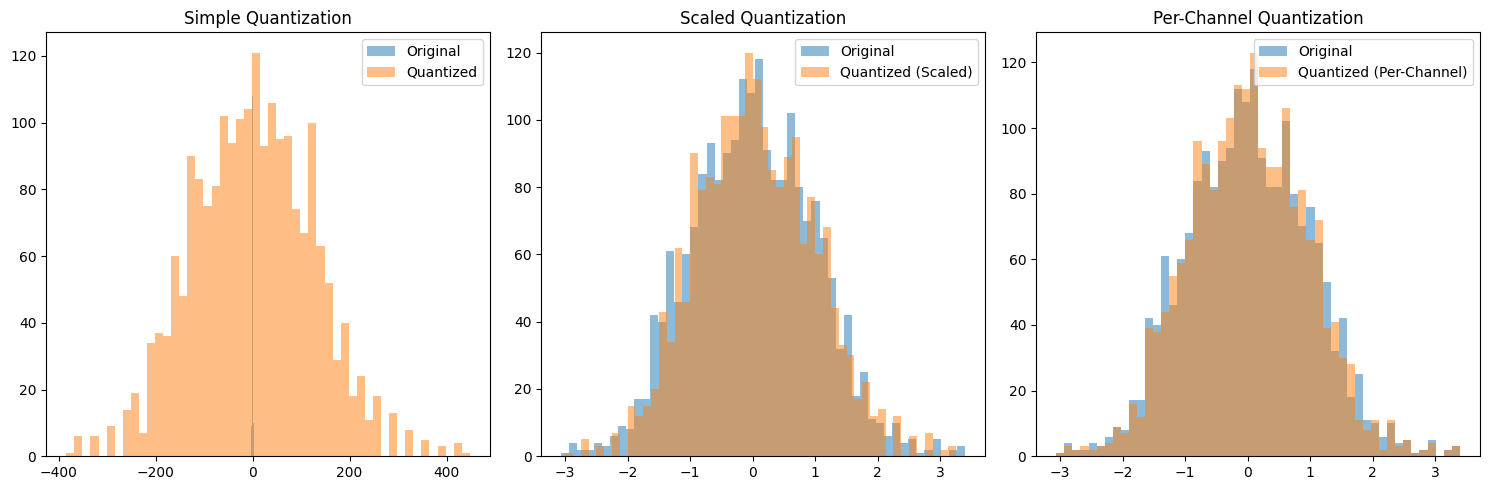


Quantization Errors (MSE):
Simple: 15344.011984
Scaled: 0.002636
Per-Channel: 0.002172


In [6]:
# Create a synthetic weight matrix
weights = np.random.normal(0, 1, (64, 32)).astype(np.float32)  # 64 output features, 32 input features

# Simple quantization (no scaling)
quantized_simple = quantize_weights(weights, Float8)

# Quantization with automatic scaling
result_scaled = quantize_weights(weights, Float8, scale_factor=1.0)
quantized_scaled = result_scaled['weights'] * result_scaled['scale']

# Per-channel quantization
result_per_channel = quantize_weights(weights, Float8, per_channel=True)
# Reshape scales to match output dimension
scales = result_per_channel['scales'].reshape(-1, 1)
quantized_per_channel = result_per_channel['weights'] * scales

# Plot weight distributions
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.hist(weights.flatten(), bins=50, alpha=0.5, label='Original')
plt.hist(quantized_simple["weights"].flatten(), bins=50, alpha=0.5, label='Quantized')
plt.title('Simple Quantization')
plt.legend()

plt.subplot(132)
plt.hist(weights.flatten(), bins=50, alpha=0.5, label='Original')
plt.hist(quantized_scaled.flatten(), bins=50, alpha=0.5, label='Quantized (Scaled)')
plt.title('Scaled Quantization')
plt.legend()

plt.subplot(133)
plt.hist(weights.flatten(), bins=50, alpha=0.5, label='Original')
plt.hist(quantized_per_channel.flatten(), bins=50, alpha=0.5, label='Quantized (Per-Channel)')
plt.title('Per-Channel Quantization')
plt.legend()

plt.tight_layout()
plt.show()

# Print quantization errors
print("\nQuantization Errors (MSE):")
print(f"Simple: {np.mean((weights - quantized_simple["weights"])**2):.6f}")
print(f"Scaled: {np.mean((weights - quantized_scaled)**2):.6f}")
print(f"Per-Channel: {np.mean((weights - quantized_per_channel)**2):.6f}")

## 3. Analyzing Quantization Effects on Different Value Ranges

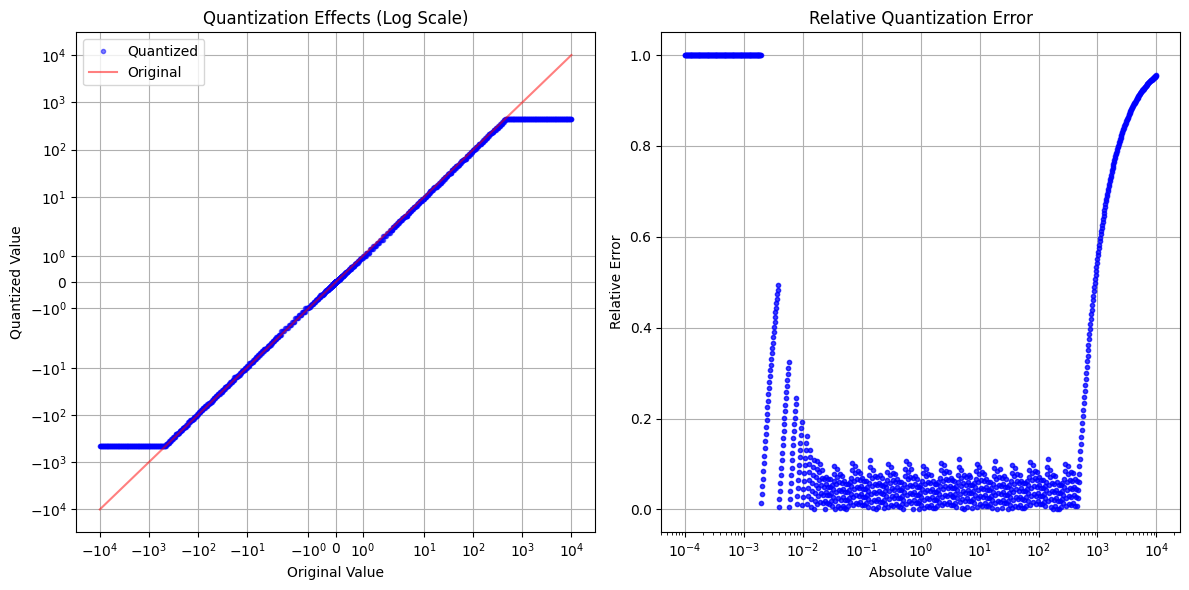

In [7]:
# Create values across different ranges
x = np.logspace(-4, 4, 1000)
values = np.concatenate([-x[::-1], [0], x])

# Quantize to Float8
quantized = np.array([float(Float8(v)) for v in values])

# Plot quantization effects
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.plot(values, quantized, 'b.', alpha=0.5, label='Quantized')
plt.plot(values, values, 'r-', alpha=0.5, label='Original')
plt.xscale('symlog')
plt.yscale('symlog')
plt.grid(True)
plt.title('Quantization Effects (Log Scale)')
plt.xlabel('Original Value')
plt.ylabel('Quantized Value')
plt.legend()

plt.subplot(122)
rel_error = np.abs((quantized - values) / (values + 1e-10))
plt.semilogx(np.abs(values), rel_error, 'b.', alpha=0.5)
plt.grid(True)
plt.title('Relative Quantization Error')
plt.xlabel('Absolute Value')
plt.ylabel('Relative Error')

plt.tight_layout()
plt.show()